# Imports

In [1]:
import torch
import torch.nn as nn
from random import shuffle
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset, RandomSampler

/Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <760F3975-CB00-30FA-8785-26E85127AF0E> /Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <5B060930-6A71-3C98-A456-D34B1C187A40> /Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently t

# Function to load fmnist dataset

In [2]:
fmnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def load_fmnist_torch(root="./data", transform=None, download=True):

    if transform == None:
        transform = T.ToTensor()

    train_set = FashionMNIST(root=root,  transform=transform, download=download, train=True)
    test_set = FashionMNIST(root=root,  transform=transform, download=download, train=False)

    # Each item in this dictionary is a torch Dataset object
    # To feed the data into a model, you may have to use a DataLoader
    return {"train": train_set, "test": test_set}

#  SmallCNN Model

In [3]:
class SmallCNN(nn.Module):

    def __init__(self):
        super(SmallCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        return out

In [4]:
# Check if CUDA is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS available! Training on GPU.", flush=True)
else:
    device = torch.device('cpu')
    print("MPS NOT available... Training on CPU.", flush=True)

MPS available! Training on GPU.


# Problem 1

In [5]:
# Load FMNIST dataset
fmnist = load_fmnist_torch()
fmnist_train = fmnist['train']
fmnist_test = fmnist['test']

trainer = DataLoader(dataset=fmnist_train, batch_size=64, shuffle=True)

train_sampler = RandomSampler(fmnist_train, num_samples=500)
test_sampler = RandomSampler(fmnist_test, num_samples=500)

train_loader = DataLoader(fmnist_train, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(fmnist_test, batch_size=64, sampler=test_sampler)

In [6]:
# TODO: Load and train mdoel
import torch.optim as optim

model = SmallCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for epoch in range(50):  # Train for 10 epochs
        print(f'Train Epoch: {epoch+1}:','\n')
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
        print('\n\n')

train(model, device, trainer, optimizer, criterion)

Train Epoch: 1: 

Train Epoch: 1 [0/60000] Loss: 2.286545
Train Epoch: 1 [6400/60000] Loss: 0.713171
Train Epoch: 1 [12800/60000] Loss: 0.270351
Train Epoch: 1 [19200/60000] Loss: 0.311354
Train Epoch: 1 [25600/60000] Loss: 0.472213
Train Epoch: 1 [32000/60000] Loss: 0.282407
Train Epoch: 1 [38400/60000] Loss: 0.173214
Train Epoch: 1 [44800/60000] Loss: 0.554105
Train Epoch: 1 [51200/60000] Loss: 0.284146
Train Epoch: 1 [57600/60000] Loss: 0.225020



Train Epoch: 2: 

Train Epoch: 2 [0/60000] Loss: 0.330136
Train Epoch: 2 [6400/60000] Loss: 0.310694
Train Epoch: 2 [12800/60000] Loss: 0.298320
Train Epoch: 2 [19200/60000] Loss: 0.308555
Train Epoch: 2 [25600/60000] Loss: 0.382470
Train Epoch: 2 [32000/60000] Loss: 0.284893
Train Epoch: 2 [38400/60000] Loss: 0.093580
Train Epoch: 2 [44800/60000] Loss: 0.272394
Train Epoch: 2 [51200/60000] Loss: 0.215496
Train Epoch: 2 [57600/60000] Loss: 0.269578



Train Epoch: 3: 

Train Epoch: 3 [0/60000] Loss: 0.295868
Train Epoch: 3 [6400/60000] Lo

In [7]:
# Compute losses
def compute_losses(model, loader):
    criterion = nn.CrossEntropyLoss(reduction='none')
    model.eval()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            losses.extend(loss.cpu().numpy())
    return np.array(losses)

In [8]:
train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

In [9]:
# Compute threshold T
T = np.mean(train_losses)
print(f'Threshold: {T:.4f}')

Threshold: 0.0112


In [10]:
# Perform attack and compute confusion matrix
y_true = np.array([1] * 500 + [0] * 500)
y_pred = np.concatenate((train_losses < T, test_losses < T)).astype(int)

In [11]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + fp + tn + fn)
error = 1 - accuracy
precision = tp / (tp + fp)

In [12]:
print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Accuracy: {accuracy:.2f}, Error: {error:.2f}, Precision: {precision:.2f}")

Confusion Matrix: TP=494, FP=483, TN=17, FN=6
Accuracy: 0.51, Error: 0.49, Precision: 0.51


In [13]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, np.concatenate((train_losses, test_losses)))
roc_auc = auc(fpr, tpr)

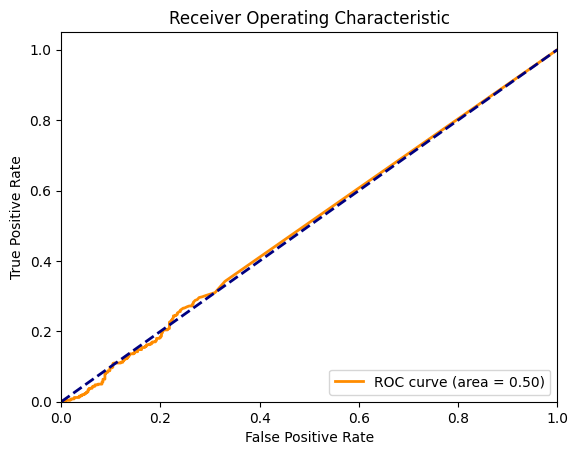

In [14]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Observations

* The attack leverages overfitting in machine learning models, where training samples tend to exhibit lower losses compared to test samples. This principle is consistent with findings by Yeom et al. [2021].
* The choice of threshold T, computed as the average loss of training samples, is crucial. A well-chosen threshold can significantly impact the True Positive Rate (TPR) and False Positive Rate (FPR), affecting the overall accuracy and precision of the attack.
* The overall accuracy of the attack is just above random guessing (50%), suggesting that the attack is not very effective in distinguishing between training and test samples.